In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import h5py

with h5py.File('../data/outputs/fields_mm.h5', 'r') as f:
    points = f['points'][:]
    fields = f['B'][:]
    d_space = f['d_space'][:]
assert points.shape == fields.shape

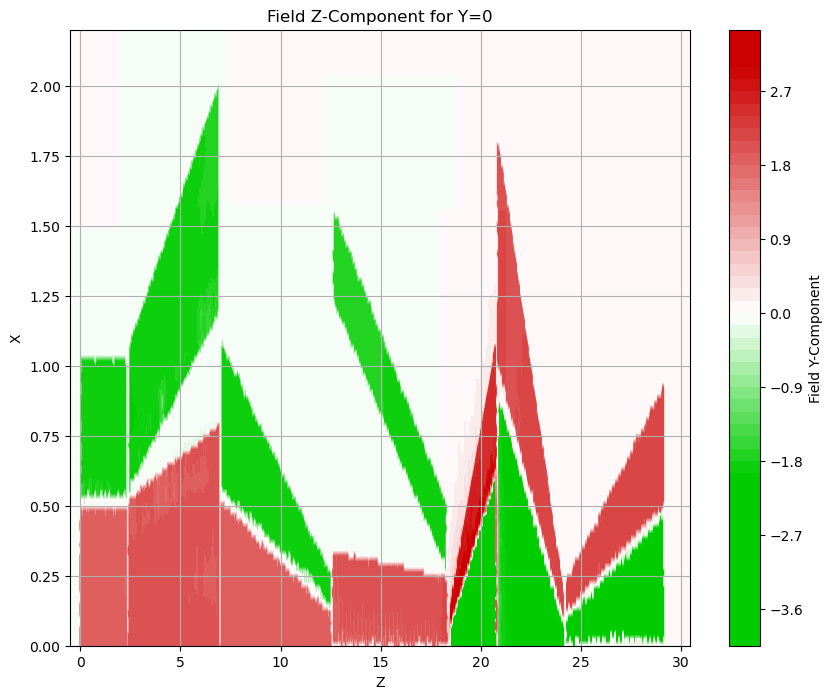

In [9]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import numpy as np
import matplotlib.pyplot as plt

# Filter points where y is approximately 0
tolerance = 1e-6
mask = np.abs(points[:, 1]) < tolerance
points_y0 = points[mask]
fields_y0 = fields[mask]

# Extract x and z coordinates for the plot
x = points_y0[:, 0]
z = points_y0[:, 2]

# Use z-component of the field instead of magnitude
field_values = fields_y0[:, 1]  # Using z-component which can be +/-

# Create custom colormap: green for negative, white at zero, red for positive
colors = [(0, 0.8, 0), (1, 1, 1), (0.8, 0, 0)]
custom_cmap = LinearSegmentedColormap.from_list('green_white_red', colors)

# Create a normalization that centers white color at value 0
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=3.0)

# Create the tricontourf plot with many more levels for a more continuous look
plt.figure(figsize=(10, 8))
# Using 100 levels instead of 20 for a more continuous appearance
tcf = plt.tricontourf(z,x, field_values, cmap=custom_cmap, levels=70, norm=norm)
plt.colorbar(tcf, label='Field Y-Component')
plt.xlabel('Z')
plt.ylabel('X')
plt.title('Field Z-Component for Y=0')
plt.grid(True)
plt.ylim(0,2.2)
plt.show()

In [25]:

def interpolate_field(point, field_data, ranges):
    """
    Nearest neighbor interpolation of magnetic field.
    
    Parameters:
    point: [x, y, z] coordinates
    field_data: array of shape (nx*ny*nz, 3) with field vectors
    ranges: dict with 'range_x', 'range_y', 'range_z' as [min, max, step]
    
    Returns:
    [Bx, By, Bz] field components
    """
    x, y, z = point
    
    # Grid parameters
    x_min, x_max, dx = np.array(ranges[0]) / 100
    y_min, y_max, dy = np.array(ranges[1]) / 100
    z_min, z_max, dz = np.array(ranges[2]) / 100
    
    nx = int(round((x_max - x_min) / dx)) + 1
    ny = int(round((y_max - y_min) / dy)) + 1
    nz = int(round((z_max - z_min) / dz)) + 1
    
    # Check bounds
    if abs(x) > x_max or abs(y) > y_max or abs(z) > z_max:
        return np.array([0.0, 0.0, 0.0])
    
    # Apply symmetry (map to first quadrant)
    sym_x, sym_y = abs(x), abs(y)
    quadrant = (1 if x >= 0 and y >= 0 else
                2 if x < 0 and y >= 0 else
                3 if x < 0 and y < 0 else 4)
    
    # Calculate indices with clamping
    i = max(0, min(int(round((sym_x - x_min) / dx)), nx - 1))
    j = max(0, min(int(round((sym_y - y_min) / dy)), ny - 1))
    k = max(0, min(int(round((z - z_min) / dz)), nz - 1))
    
    # Flat index: j*(nx*nz) + i*nz + k
    idx = j * (nx * nz) + i * nz + k
    
    # Get field
    B_field = field_data[idx].copy()
    
    # Apply field symmetry
    if quadrant == 2 or quadrant == 4:
        B_field[0] = -B_field[0]  # Flip Bx
    if quadrant == 3 or quadrant == 4:
        B_field[2] = -B_field[2]  # Flip Bz
    
    return B_field


def plot_field_slices(field_data, ranges, n_points=100):
    """
    Fast plotting using vectorized operations for both X=0 and Y=0 slices.
    """
    x_min, x_max = -2.2, 2.2
    z_min, z_max = -1, 32
    y_min,y_max = -2.2,2.2
    
    # Create evaluation grids for both slices
    y_eval = np.linspace(y_min, y_max, n_points)
    z_eval = np.linspace(z_min, z_max, n_points)
    x_eval = np.linspace(x_min, x_max, n_points)
    
    # Y=0 slice (X vs Z)
    Y_xz, Z_xz = np.meshgrid(x_eval, z_eval)
    x_flat_xz = Y_xz.flatten()
    z_flat_xz = Z_xz.flatten()
    field_values_xz = np.array([interpolate_field([x, 0.0, z], field_data, ranges)[1] 
                               for x, z in zip(x_flat_xz, z_flat_xz)])
    
    # X=0 slice (Y vs Z)
    Y_yz, Z_yz = np.meshgrid(y_eval, z_eval)
    y_flat_yz = Y_yz.flatten()
    z_flat_yz = Z_yz.flatten()
    field_values_yz = np.array([interpolate_field([0.0, y, z], field_data, ranges)[1] 
                               for y, z in zip(y_flat_yz, z_flat_yz)])
    
    # Plot side by side
    colors = [(0, 0.8, 0), (1, 1, 1), (0.8, 0, 0)]
    custom_cmap = LinearSegmentedColormap.from_list('green_white_red', colors)
    norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=6)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Y=0 slice
    tcf1 = ax1.tricontourf(z_flat_xz, x_flat_xz, field_values_xz, 
                          cmap=custom_cmap, levels=70, norm=norm)
    ax1.set_xlabel('Z (m)')
    ax1.set_ylabel('X (m)')
    ax1.set_title('Magnetic Field Y=0 Slice')
    ax1.grid(True, alpha=0.3)
    
    # X=0 slice  
    tcf2 = ax2.tricontourf(z_flat_yz, y_flat_yz, field_values_yz,
                          cmap=custom_cmap, levels=70, norm=norm)
    ax2.set_xlabel('Z (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('Magnetic Field X=0 Slice')
    ax2.grid(True, alpha=0.3)
    
    # Shared colorbar
    #plt.colorbar(tcf1, ax=[ax1, ax2], label='Field Y-Component (T)')
    plt.tight_layout()
    plt.show()

/disk/users/lprate/mytmp/ipykernel_165199/2544790784.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


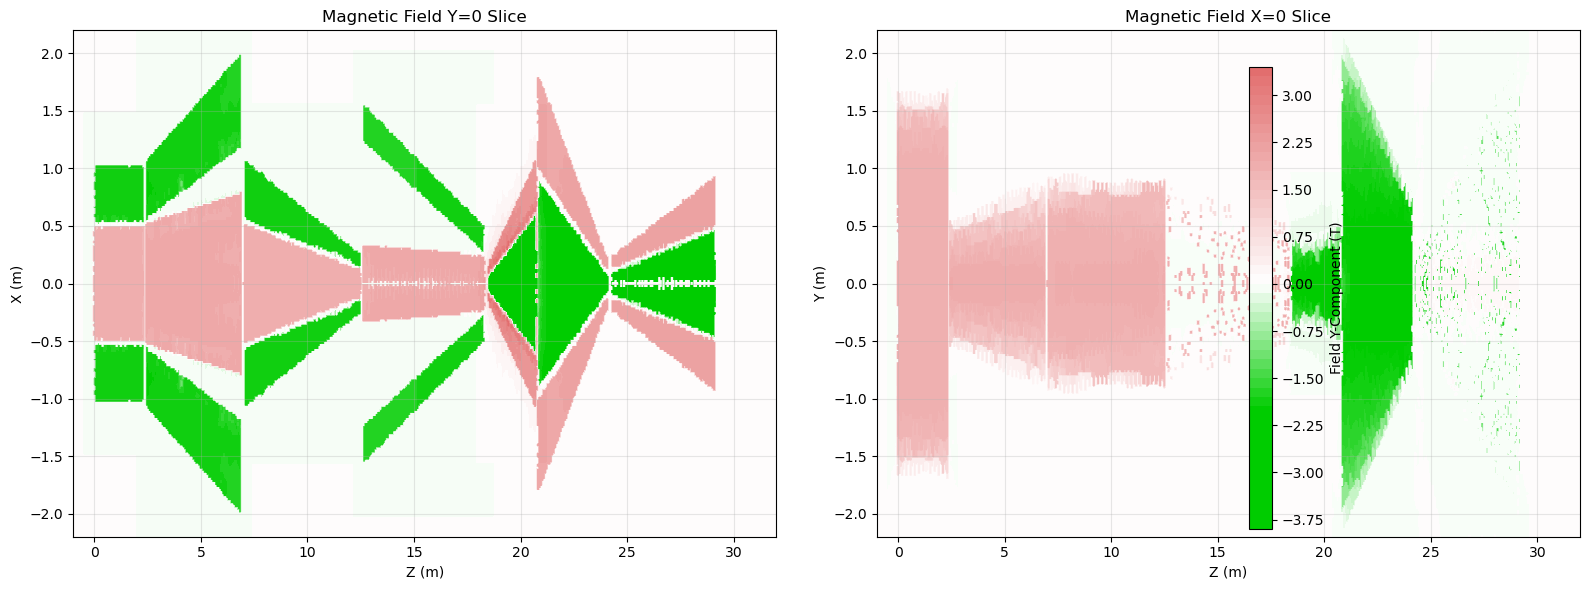

In [24]:
plot_field_slices(fields, d_space, n_points = 500)